In [7]:
import pandas as pd
import lxml.etree

tree = lxml.etree.parse('Batchablauf.xml')
root = tree.getroot()

df_batch = pd.DataFrame(columns = ['batchId', 'batchName', 'batchKurzname', 'note'])

predecessor_successor_array = [[]]
batches=root.findall('.//Heading[@Level="2"]')
index = 0
for i, batch in enumerate(batches, start=0):
    batchId = batch.attrib['UUID']
    batchName = batch.find('HeadingText[1]').text
    batchKurzname_result = batch.xpath('.//HeadingText[text()="Kurzname"]/following-sibling::Paragraph/run')
    batchKurzname = batchKurzname_result[0].text if len(batchKurzname_result) > 0 else batchName
    df_batch.loc[index] = [batchId, batchName, batchKurzname, ""]
    index += 1
    successor = batch.xpath('.//HeadingText[text()="Ziel"]/following-sibling::Heading')[0]
    #successorId = batch.xpath('.//HeadingText[text()="Ziel"]/following-sibling::Heading/attribute::UUID')[0]
    successorId = successor.attrib['UUID']
    if len(df_batch[df_batch['batchId'] == successorId]) == 0:
        successorName = successor.find('HeadingText[1]').text
        df_batch.loc[index] = [successorId, successorName, successorName, ""]
        index += 1
    predecessor_successor_array.append([batchId,successorId])

df_graph = pd.DataFrame(columns = ['predecessorId', 'successorId'], data=predecessor_successor_array)
df_graph.dropna(axis=0, how='any', thresh=None, subset=None, inplace=True)

df_graph.to_csv('batchgraph.csv', index=False)
df_batch.to_csv('batch.csv', index=False)

In [8]:
#print(df_batch.loc[df_batch['batchId'] == '9210d55d-e720-071a-2ab0-b916396cc556'])
print(df_batch.loc[df_batch['batchId'] == 'fc1db4a1-dbbc-db62-a574-eb92da4a606b'])
df_batch.head()

                                 batchId         batchName     batchKurzname  \
16  fc1db4a1-dbbc-db62-a574-eb92da4a606b  Parallelisierung  Parallelisierung   

   note  
16       


,batchId,batchName,batchKurzname,note
0,ad19d7e3-d6b0-9174-214c-10ae52b36f5f,Start,Start,
1,097fe55c-c134-88cf-238b-5aec0e83a4a6,Verzweigung_138,Verzweigung_138,
2,53155764-a023-92eb-c1a2-b39c84db7c9e,Verzweigung,Verzweigung,
3,e4b903af-7ed0-02da-5b56-86223f5b620b,Parallelisierung_2,Parallelisierung_2,
4,097fe55c-c134-88cf-238b-5aec0e83a4a6,Verzweigung_138,Verzweigung_138,


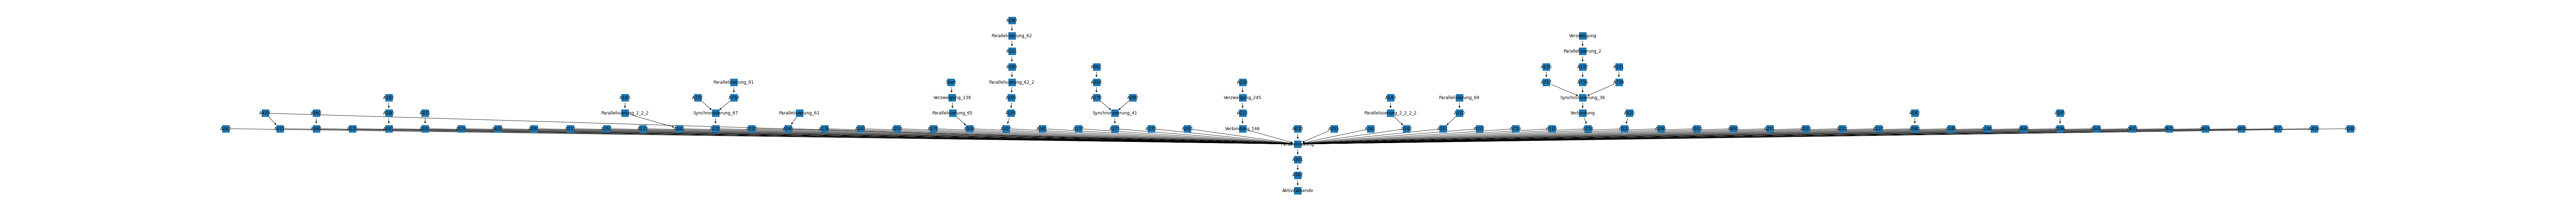

In [11]:
# Anaconda Prompt:
#   conda install -c alubbock pygraphviz
#   dot -c
import networkx as nx
import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout

G = nx.from_pandas_edgelist(df_graph, 'predecessorId', 'successorId', create_using=nx.DiGraph)
label_dict = df_batch.set_index('batchId')['batchKurzname'].to_dict()
nx.relabel_nodes(G,label_dict,False)
pos = graphviz_layout(G, prog="dot", root=1, args='-Gsplines=true -Gsep=1 -Goverlap=false -Gorientation=10')
plt.figure(figsize=(100, 8))

#plt.gca().invert_yaxis()
nx.draw(G, pos=pos, with_labels=True,  node_shape="s", node_size=400, linewidths=1)